<a href="https://colab.research.google.com/github/bahulkark/Building-your-Deep-Neural-Network-Step-by-Step/blob/master/slt02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have implemented a two layer perceptron with backpropagation. All the information about the datasets as well as helper functions is given inline. 

In [0]:

#Generic imports of libraries and setting up the notebook .

import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [0]:

def sigmoid(Z):

    # simple sigmoid activation function
    
    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):

    # simple relu activation funciton implementation. 
    
    A = np.maximum(0,Z)
    
    cache = Z 
    #returns cache and activation output. 

    return A, cache


def relu_B(dA, cache):
    """
    backward propagation of relu activation function .
    """

    Z = cache
    dZ = np.array(dA, copy=True) # converting dA to numpy array
    
    # When z <= 0, you should set dz to 0 as well. thats' derivative of relu function 
    dZ[Z <= 0] = 0
  
    return dZ

def sigmoid_B(dA, cache):
    """
    implementation of sigmoid function. 

    """
    
    Z = cache
    
    # sigmoid output 
    s = 1/(1+np.exp(-Z))

    # using chain rule : calculating the sigmoid backward function. 
    dZ = dA * s * (1-s)
    

    
    #return gradient of sigmoid.

    return dZ


def load_setup_data():
    '''
    ABOUT DATASET: 

    I got this dataset from github. Its a simple dataset containing cat pictures(of course non-cat pictures as well)

    Below code just preprocesses  the data and retrives train/test data and lables seperately. 
    '''

    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # returns flattend dataset of trian, test as well as the corresponding classes.
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def init_parameters(n_x, n_h, n_y):
    """
    This functin is designed specifically for two-layer neural net. 
    returns weights of shape 
                            W1 = weight scaled random matrix, (n_h, n_x)
                            b1 = zeros (n_h, 1)
                            W2 = weight scaled random matrix, (n_y, n_h)
                            b2 = zeros (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    # returns dictionary of these values. 

    return parameters     


def linear_forward(A, W, b):
    """
    Implementation of simple linear forward propagation. 
    inputs:
            A: input 
            W: weights 
            b: bias 

    computs and returns WA + b stored in a cache. 
    """
    
    Z = W.dot(A) + b

    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implementatio of linear activation forward. i.e linear forward with some activation function .
    calls the linear_forward function and then applies the non-linear activation to the output cache.

    """

    Z, linear_cache = linear_forward(A_prev, W, b)

    # if the activation is sigmoid . call sigmoid on output
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    # returns the non-linear ouptut with the activation and linear cache enclosed in the tuple cache. 
    return A, cache


def linear_B(dZ, cache):
    """
    implementation of single backprob step. 

    Args:
    dZ -- gradient of cost wrt. input
    cache -- tuple of values (A_prev, W, b) output of the forward propagation in the current layer

    Returns:
    dA_prev -- gradient of the cost wrt. to previous layer
    dW -- gradient of the cost wrt. W
    db -- gradient of the cost wrt. b 

    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def linear_activation_B(dA, cache, activation):
    """
    Simple extention to linear backward function. 
    it first calculates the activation gradient
    then we call the linear_backward function. 
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_B(dA, activation_cache)
        dA_prev, dW, db = linear_B(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_B(dA, activation_cache)
        dA_prev, dW, db = linear_B(dZ, linear_cache)
    
    return dA_prev, dW, db



def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    """
  
    P = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for p in range(P):
        parameters["W" + str(p+1)] = parameters["W" + str(p+1)] - learning_rate * grads["dW" + str(p+1)]
        parameters["b" + str(p+1)] = parameters["b" + str(p+1)] - learning_rate * grads["db" + str(p+1)]
        
    return parameters

def zero_one(X, y, parameters):
    """
    This function returns the accuracy of the trained model .

    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    A1, _ = linear_activation_forward(X, parameters['W1'], parameters['b1'], "relu")
    probas, _ = linear_activation_forward(A1, parameters['W2'], parameters['b2'], "sigmoid")
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    

    acc_ = np.sum((p == y)/m)
   
    return 1-acc_



In [0]:
# loading data. 

train_x_orig, train_y, test_x_orig, test_y, classes = load_setup_data()

In [0]:
# Understanding the dataset. 

m_train = train_x_orig.shape[0]  #Number of training examples
num_px = train_x_orig.shape[1]   #Size of each image
m_test = test_x_orig.shape[0]    #Number of testing examples



In [0]:
# Reshaping the training and test examples to ease up the computation.  
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1. eases in the gradient descent rule. 

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

#We just reshaped the input data into (64 x 64 x 3 , #samples) for both train and test examples


In [0]:

def MLP(X, Y, X_test, Y_test, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Simple MLP that works as Linear->RELU->Linear->SIGMOID

    Arguments:
    X -- input train data, of shape (n_x, number of examples)
    Y -- true "label" vector for train data of shape (1, number of examples) ( y = 1 if cat, 0 otherwise)
    X_test -- input test data, of shape( n_x, number of examples)
    Y_test -- true "label" vector for test data of shape (1 , number of examples)  (y = 1 if cat, 0 otherwise) 
    layers_dims -- dimensions of the layers of the perceptron (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    errors_test = []                         # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    np.random.seed(1)
    grads = {}
    errors = []     

    
    #initilize parametes using already defined function.  
    parameters = init_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        
        #gradient of 
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_B(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_B(dA1, cache1, "relu")
        
        # Seting up grads dictionary
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        #gradient descent update procedure
        parameters = update_parameters( parameters, grads, learning_rate)
        cost = zero_one(X, Y, parameters)
        cost_test  = zero_one(X_test, Y_test, parameters)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            errors.append(cost)
            errors_test.append(cost_test)
       
    # plot the cost

    plt.plot(np.squeeze(errors), label= "train Error")
    plt.plot(np.squeeze(errors_test), label= "test Error")

    plt.legend(loc = "upper right")

    plt.ylabel('Error')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return errors[-1], errors_test[-1]

First we'll retrive the best model parameters and then using those parameters we'll see the effect of training it on variable amount of data
Training Model with hidden layer size 5 and learning rate 0.001 
Cost after iteration 0: 0.6555023923444976
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.3444976076555024
Cost after iteration 1100: 0.3444976076555024
Cost after iteration 1200: 0.3444976076555024
Cost after iteration 1300: 0.3444976076555024
Cost after iteration 1400: 0.3444976076555024
Cost after iteration 1500: 0.3444976076555024
Cost after iteration 1600: 0.3444976076555024
Cost after iteration 170

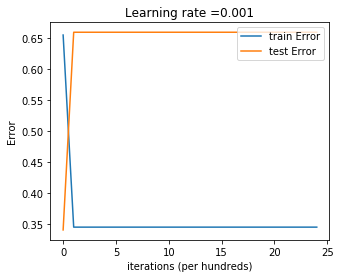

Training Model with hidden layer size 5 and learning rate 0.005 
Cost after iteration 0: 0.6507177033492824
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.21052631578947378
Cost after iteration 1100: 0.13397129186602885
Cost after iteration 1200: 0.11483253588516762
Cost after iteration 1300: 0.10047846889952172
Cost after iteration 1400: 0.08612440191387583
Cost after iteration 1500: 0.07655502392344515
Cost after iteration 1600: 0.06698564593301448
Cost after iteration 1700: 0.05741626794258392
Cost after iteration 1800: 0.04784688995215336
Cost after iteration 1900: 0.043062200956938024
Cost after itera

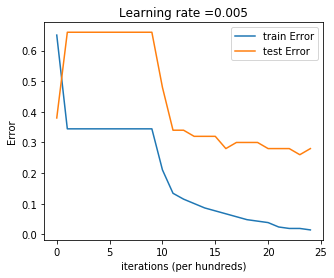

Training Model with hidden layer size 5 and learning rate 0.0075 
Cost after iteration 0: 0.6555023923444976
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.2583732057416268
Cost after iteration 800: 0.15789473684210542
Cost after iteration 900: 0.2583732057416268
Cost after iteration 1000: 0.23444976076555035
Cost after iteration 1100: 0.17224880382775132
Cost after iteration 1200: 0.12440191387559829
Cost after iteration 1300: 0.1100478468899524
Cost after iteration 1400: 0.07177033492822982
Cost after iteration 1500: 0.03827751196172269
Cost after iteration 1600: 0.19617224880382778
Cost after iteration 1700: 0.019138755980861455
Cost after iteration 1800: 0.009569377990430783
Cost after iteration 1900: 0.009569377990430783
Cost after it

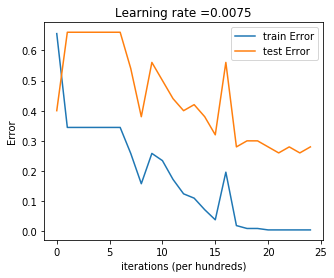

Training Model with hidden layer size 5 and learning rate 0.02 
Cost after iteration 0: 0.6124401913875598
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.2966507177033494
Cost after iteration 400: 0.20095693779904322
Cost after iteration 500: 0.15311004784689008
Cost after iteration 600: 0.15311004784689008
Cost after iteration 700: 0.11483253588516762
Cost after iteration 800: 0.05741626794258392
Cost after iteration 900: 0.06220095693779926
Cost after iteration 1000: 0.019138755980861455
Cost after iteration 1100: 0.014354066985646119
Cost after iteration 1200: 0.009569377990430894
Cost after iteration 1300: 0.004784688995215558
Cost after iteration 1400: 0.004784688995215558
Cost after iteration 1500: 0.004784688995215558
Cost after iteration 1600: 0.004784688995215558
Cost after iteration 1700: 2.220446049250313e-16
Cost after iteration 1800: 2.220446049250313e-16
Cost after iteration 1900: 2.220446049250313e-16

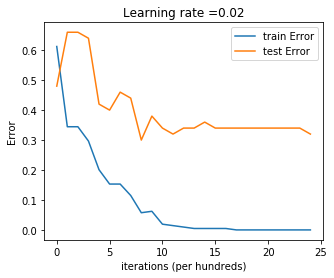

Training Model with hidden layer size 7 and learning rate 0.001 
Cost after iteration 0: 0.4688995215311005
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.3444976076555024
Cost after iteration 1100: 0.3444976076555024
Cost after iteration 1200: 0.3444976076555024
Cost after iteration 1300: 0.3444976076555024
Cost after iteration 1400: 0.3444976076555024
Cost after iteration 1500: 0.3444976076555024
Cost after iteration 1600: 0.3444976076555024
Cost after iteration 1700: 0.3444976076555024
Cost after iteration 1800: 0.3444976076555024
Cost after iteration 1900: 0.3444976076555024
Cost after iteration 2000: 

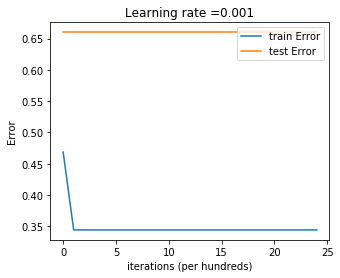

Training Model with hidden layer size 7 and learning rate 0.005 
Cost after iteration 0: 0.4401913875598086
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.17224880382775132
Cost after iteration 1100: 0.11961722488038284
Cost after iteration 1200: 0.11004784688995228
Cost after iteration 1300: 0.08612440191387583
Cost after iteration 1400: 0.06698564593301448
Cost after iteration 1500: 0.06220095693779926
Cost after iteration 1600: 0.052631578947368585
Cost after iteration 1700: 0.052631578947368585
Cost after iteration 1800: 0.04784688995215336
Cost after iteration 1900: 0.04784688995215336
Cost after iter

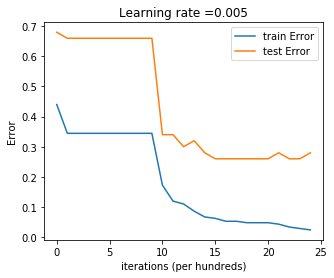

Training Model with hidden layer size 7 and learning rate 0.0075 
Cost after iteration 0: 0.4258373205741628
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.11483253588516762
Cost after iteration 800: 0.12918660287081363
Cost after iteration 900: 0.10526315789473695
Cost after iteration 1000: 0.11961722488038296
Cost after iteration 1100: 0.10047846889952172
Cost after iteration 1200: 0.08612440191387583
Cost after iteration 1300: 0.07655502392344515
Cost after iteration 1400: 0.05741626794258392
Cost after iteration 1500: 0.052631578947368585
Cost after iteration 1600: 0.04784688995215336
Cost after iteration 1700: 0.028708133971292016
Cost after iteration 1800: 0.028708133971292016
Cost after iteration 1900: 0.014354066985646119
Cost afte

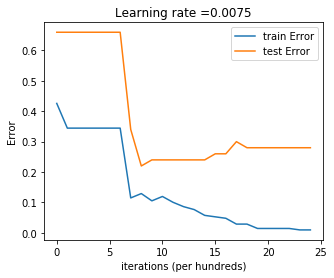

Training Model with hidden layer size 7 and learning rate 0.02 
Cost after iteration 0: 0.3732057416267942
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.2966507177033493
Cost after iteration 400: 0.22966507177033502
Cost after iteration 500: 0.18660287081339733
Cost after iteration 600: 0.09569377990430639
Cost after iteration 700: 0.14354066985645952
Cost after iteration 800: 0.07655502392344515
Cost after iteration 900: 0.052631578947368585
Cost after iteration 1000: 0.052631578947368585
Cost after iteration 1100: 0.014354066985646119
Cost after iteration 1200: 0.014354066985646119
Cost after iteration 1300: 2.220446049250313e-16
Cost after iteration 1400: 0.004784688995215558
Cost after iteration 1500: 2.220446049250313e-16
Cost after iteration 1600: 2.220446049250313e-16
Cost after iteration 1700: 2.220446049250313e-16
Cost after iteration 1800: 2.220446049250313e-16
Cost after iteration 1900: 2.220446049250313

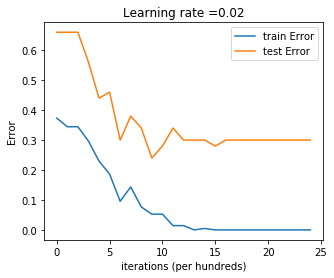

Training Model with hidden layer size 10 and learning rate 0.001 
Cost after iteration 0: 0.3444976076555024
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.3444976076555024
Cost after iteration 1100: 0.3444976076555024
Cost after iteration 1200: 0.3444976076555024
Cost after iteration 1300: 0.3444976076555024
Cost after iteration 1400: 0.3444976076555024
Cost after iteration 1500: 0.3444976076555024
Cost after iteration 1600: 0.3444976076555024
Cost after iteration 1700: 0.3444976076555024
Cost after iteration 1800: 0.3444976076555024
Cost after iteration 1900: 0.3444976076555024
Cost after iteration 2000:

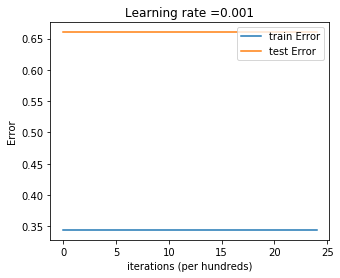

Training Model with hidden layer size 10 and learning rate 0.005 
Cost after iteration 0: 0.3444976076555024
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.2440191387559809
Cost after iteration 900: 0.18660287081339733
Cost after iteration 1000: 0.11961722488038296
Cost after iteration 1100: 0.10047846889952172
Cost after iteration 1200: 0.08612440191387571
Cost after iteration 1300: 0.05741626794258392
Cost after iteration 1400: 0.04784688995215325
Cost after iteration 1500: 0.04306220095693791
Cost after iteration 1600: 0.03827751196172269
Cost after iteration 1700: 0.03349282296650746
Cost after iteration 1800: 0.03349282296650746
Cost after iteration 1900: 0.02392344497607679
Cost after iter

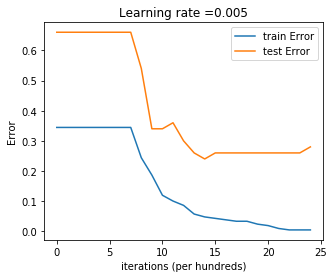

Training Model with hidden layer size 10 and learning rate 0.0075 
Cost after iteration 0: 0.3444976076555024
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3157894736842105
Cost after iteration 600: 0.16746411483253598
Cost after iteration 700: 0.11961722488038284
Cost after iteration 800: 0.13397129186602885
Cost after iteration 900: 0.11961722488038284
Cost after iteration 1000: 0.1100478468899524
Cost after iteration 1100: 0.08133971291866049
Cost after iteration 1200: 0.07177033492822982
Cost after iteration 1300: 0.03827751196172269
Cost after iteration 1400: 0.03827751196172269
Cost after iteration 1500: 0.02392344497607679
Cost after iteration 1600: 0.028708133971292127
Cost after iteration 1700: 0.019138755980861455
Cost after iteration 1800: 0.019138755980861455
Cost after iteration 1900: 0.004784688995215558
Cost aft

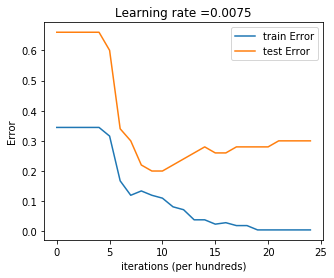

Training Model with hidden layer size 10 and learning rate 0.02 
Cost after iteration 0: 0.3444976076555024
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3397129186602872
Cost after iteration 300: 0.32057416267942584
Cost after iteration 400: 0.26315789473684226
Cost after iteration 500: 0.16267942583732076
Cost after iteration 600: 0.20574162679425845
Cost after iteration 700: 0.05741626794258392
Cost after iteration 800: 0.04784688995215336
Cost after iteration 900: 0.18181818181818188
Cost after iteration 1000: 0.019138755980861455
Cost after iteration 1100: 0.009569377990430783
Cost after iteration 1200: 0.004784688995215558
Cost after iteration 1300: 0.004784688995215558
Cost after iteration 1400: 0.004784688995215558
Cost after iteration 1500: 2.220446049250313e-16
Cost after iteration 1600: 2.220446049250313e-16
Cost after iteration 1700: 2.220446049250313e-16
Cost after iteration 1800: 2.220446049250313e-16
Cost after iteration 1900: 2.220446049250313

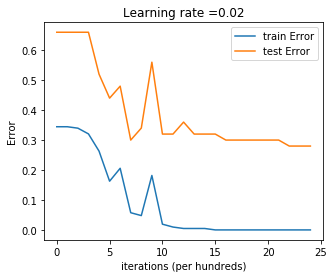

Training Model with hidden layer size 15 and learning rate 0.001 
Cost after iteration 0: 0.6363636363636364
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3444976076555024
Cost after iteration 700: 0.3444976076555024
Cost after iteration 800: 0.3444976076555024
Cost after iteration 900: 0.3444976076555024
Cost after iteration 1000: 0.3444976076555024
Cost after iteration 1100: 0.3444976076555024
Cost after iteration 1200: 0.3444976076555024
Cost after iteration 1300: 0.3444976076555024
Cost after iteration 1400: 0.3444976076555024
Cost after iteration 1500: 0.3444976076555024
Cost after iteration 1600: 0.3444976076555024
Cost after iteration 1700: 0.3444976076555024
Cost after iteration 1800: 0.3444976076555024
Cost after iteration 1900: 0.3444976076555024
Cost after iteration 2000:

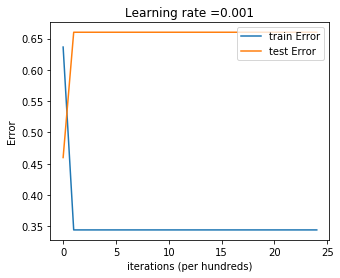

Training Model with hidden layer size 15 and learning rate 0.005 
Cost after iteration 0: 0.6267942583732058
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3444976076555024
Cost after iteration 500: 0.3444976076555024
Cost after iteration 600: 0.3301435406698565
Cost after iteration 700: 0.2679425837320575
Cost after iteration 800: 0.22488038277511968
Cost after iteration 900: 0.1435406698564594
Cost after iteration 1000: 0.10526315789473695
Cost after iteration 1100: 0.10047846889952172
Cost after iteration 1200: 0.08612440191387571
Cost after iteration 1300: 0.06220095693779926
Cost after iteration 1400: 0.05741626794258392
Cost after iteration 1500: 0.04306220095693791
Cost after iteration 1600: 0.03827751196172269
Cost after iteration 1700: 0.028708133971292016
Cost after iteration 1800: 0.019138755980861455
Cost after iteration 1900: 0.019138755980861455
Cost after i

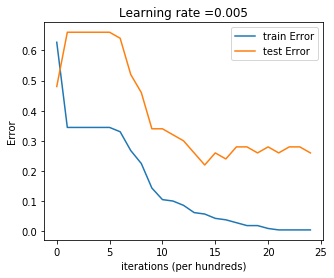

Training Model with hidden layer size 15 and learning rate 0.0075 
Cost after iteration 0: 0.6028708133971292
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3444976076555024
Cost after iteration 300: 0.3444976076555024
Cost after iteration 400: 0.3301435406698565
Cost after iteration 500: 0.2440191387559809
Cost after iteration 600: 0.16267942583732076
Cost after iteration 700: 0.1387559808612442
Cost after iteration 800: 0.17703349282296665
Cost after iteration 900: 0.16267942583732076
Cost after iteration 1000: 0.12918660287081352
Cost after iteration 1100: 0.10047846889952172
Cost after iteration 1200: 0.07655502392344515
Cost after iteration 1300: 0.03349282296650746
Cost after iteration 1400: 0.14832535885167475
Cost after iteration 1500: 0.009569377990430894
Cost after iteration 1600: 0.004784688995215558
Cost after iteration 1700: 0.004784688995215558
Cost after iteration 1800: 0.004784688995215558
Cost after iteration 1900: 0.004784688995215558
Cost af

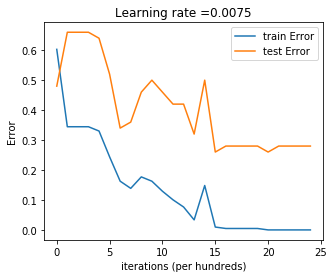

Training Model with hidden layer size 15 and learning rate 0.02 
Cost after iteration 0: 0.47846889952153104
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3301435406698565
Cost after iteration 300: 0.2870813397129187
Cost after iteration 400: 0.2535885167464116
Cost after iteration 500: 0.2009569377990431
Cost after iteration 600: 0.12918660287081352
Cost after iteration 700: 0.07655502392344515
Cost after iteration 800: 0.03349282296650746
Cost after iteration 900: 2.220446049250313e-16
Cost after iteration 1000: 2.220446049250313e-16
Cost after iteration 1100: 2.220446049250313e-16
Cost after iteration 1200: 2.220446049250313e-16
Cost after iteration 1300: 2.220446049250313e-16
Cost after iteration 1400: 2.220446049250313e-16
Cost after iteration 1500: 2.220446049250313e-16
Cost after iteration 1600: 2.220446049250313e-16
Cost after iteration 1700: 2.220446049250313e-16
Cost after iteration 1800: 2.220446049250313e-16
Cost after iteration 1900: 2.2204460492

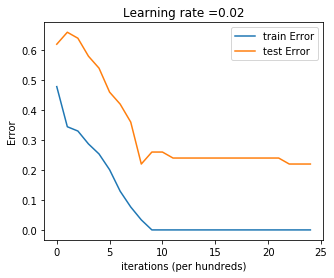

In [7]:
print("First we'll retrive the best model parameters and then using those parameters we'll see the effect of training it on variable amount of data")

best_error = 1000 
b_lr = 0
b_h_s = 0


#Defining the model 
# We'll experiment with different paramaetes and hyper parameters 

n_x = 12288     # num_px * num_px * 3
n_hidden = [5, 7, 10, 15]          # no of neuron units in the hidden  layer.
n_y = 1         # no. of output(s)
lr = [.001, .005, .0075, .02]
for curr_hidden_size in n_hidden:
  for lr_ in lr:
    print("Training Model with hidden layer size {} and learning rate {} " .format(curr_hidden_size, lr_))
    e_ , et_  = MLP(train_x, train_y, test_x, test_y, layers_dims = (n_x, curr_hidden_size, n_y), learning_rate= lr_, num_iterations = 2500, print_cost=True)
    if(e_ < best_error):
      b_lr = lr_
      b_hs = curr_hidden_size 

** Now that we have the best parameters we'll see how it works on the number of training data.**




Cost after iteration 0: 0.30000000000000004
Cost after iteration 100: 0.05999999999999983
Cost after iteration 200: 0.0
Cost after iteration 300: 0.0
Cost after iteration 400: 0.0
Cost after iteration 500: 0.0
Cost after iteration 600: 0.0
Cost after iteration 700: 0.0
Cost after iteration 800: 0.0
Cost after iteration 900: 0.0
Cost after iteration 1000: 0.0
Cost after iteration 1100: 0.0
Cost after iteration 1200: 0.0
Cost after iteration 1300: 0.0
Cost after iteration 1400: 0.0
Cost after iteration 1500: 0.0
Cost after iteration 1600: 0.0
Cost after iteration 1700: 0.0
Cost after iteration 1800: 0.0
Cost after iteration 1900: 0.0
Cost after iteration 2000: 0.0
Cost after iteration 2100: 0.0
Cost after iteration 2200: 0.0
Cost after iteration 2300: 0.0
Cost after iteration 2400: 0.0


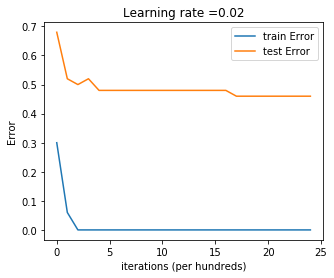

Cost after iteration 0: 0.33999999999999997
Cost after iteration 100: 0.25
Cost after iteration 200: 0.1100000000000001
Cost after iteration 300: 0.09000000000000008
Cost after iteration 400: 0.010000000000000009
Cost after iteration 500: 1.1102230246251565e-16
Cost after iteration 600: 1.1102230246251565e-16
Cost after iteration 700: 1.1102230246251565e-16
Cost after iteration 800: 1.1102230246251565e-16
Cost after iteration 900: 1.1102230246251565e-16
Cost after iteration 1000: 1.1102230246251565e-16
Cost after iteration 1100: 1.1102230246251565e-16
Cost after iteration 1200: 1.1102230246251565e-16
Cost after iteration 1300: 1.1102230246251565e-16
Cost after iteration 1400: 1.1102230246251565e-16
Cost after iteration 1500: 1.1102230246251565e-16
Cost after iteration 1600: 1.1102230246251565e-16
Cost after iteration 1700: 1.1102230246251565e-16
Cost after iteration 1800: 1.1102230246251565e-16
Cost after iteration 1900: 1.1102230246251565e-16
Cost after iteration 2000: 1.1102230246251

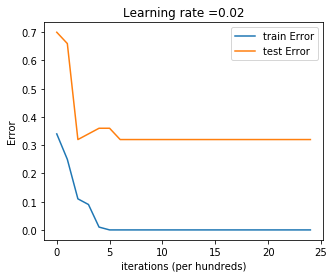

Cost after iteration 0: 0.47846889952153104
Cost after iteration 100: 0.3444976076555024
Cost after iteration 200: 0.3301435406698565
Cost after iteration 300: 0.2870813397129187
Cost after iteration 400: 0.2535885167464116
Cost after iteration 500: 0.2009569377990431
Cost after iteration 600: 0.12918660287081352
Cost after iteration 700: 0.07655502392344515
Cost after iteration 800: 0.03349282296650746
Cost after iteration 900: 2.220446049250313e-16
Cost after iteration 1000: 2.220446049250313e-16
Cost after iteration 1100: 2.220446049250313e-16
Cost after iteration 1200: 2.220446049250313e-16
Cost after iteration 1300: 2.220446049250313e-16
Cost after iteration 1400: 2.220446049250313e-16
Cost after iteration 1500: 2.220446049250313e-16
Cost after iteration 1600: 2.220446049250313e-16
Cost after iteration 1700: 2.220446049250313e-16
Cost after iteration 1800: 2.220446049250313e-16
Cost after iteration 1900: 2.220446049250313e-16
Cost after iteration 2000: 2.220446049250313e-16
Cost a

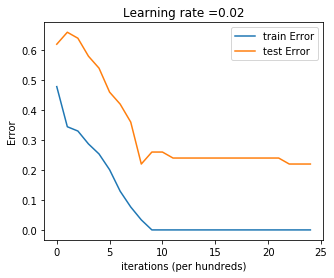

In [8]:
sample_cut = [50, 100, 209]
for cut_ in sample_cut:
  _ = MLP(train_x[:, :cut_], train_y[: , :cut_], test_x, test_y, layers_dims = (n_x, b_hs, n_y), learning_rate= b_lr, num_iterations = 2500, print_cost=True)


As we can see above, using our best parameters and variable train set size, we are able to notice that 

1.   The first model overfits, fails miserably on test set
2.   The second model performs better than the first model
3.   The third model trained on the entire model perfroms even better and gets the test error even low compared to the above two models. 

We can clearly notice the effects of increasing train data: it tires to genralize better. 
As our model was limited with training data, we got "not so smooth" curves but if we had given more training data we would have produced even smoother curves with train and test error with reduced gap between them.

Also, we notice several intresting things


1.   Testing error never reaches/crosses training error (the main problem of machine learning)
2.   It goes on decreasing with every new model that is being trained with larger dataset. 

NOTE: Error is defined as the fraction of samples incorrectly predicted.



